**Imports** 🕵️‍♂️

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from scipy.signal import detrend
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import ReduceLROnPlateau

**Functions** 🤌

In [2]:
def create_lag_features(df, column, max_lag):
    """
    Creates lagged features for a specific column.
    """
    for lag in range(1, max_lag + 1):
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
    return df


def create_rolling_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i : (i + window_size), :])
        y.append(data[(i + window_size) : (i + window_size + forecast_horizon), 0])
    return np.array(X), np.array(y)


def preprocess_data(feature_names, window_size, forecast_horizon, drop_features):
    # Load the data
    df = pd.read_csv(
        "../../../data/kc/btc/heiken_ashi/with_trade_indicators/raw/kc_btc_15min_ha_ti.csv"
    )

    # Convert color to 0 for 'red' and 1 for 'green'
    df["color"] = df["color"].map({"red": 0, "green": 1})

    # Add 'color_change' column: 1 if color changes from the previous row, 0 otherwise
    df["color_change"] = df["color"].diff().abs()

    # Fill the first row's 'color_change' with 0
    df["color_change"].fillna(0, inplace=True)

    # Drop 'time'
    df = df.drop(["time"], axis=1)

    # Create lag features for 'turnover', 'CCI_5', 'BBP_5_2.0_5', 'color', 'BBP_10_2.0_10', 'RVI_5', 'CCI_10', 'BBB_5_2.0_5'
    df = create_lag_features(
        df, "turnover", max_lag=3
    )  # Create 3 lagged features for 'turnover'
    df = create_lag_features(
        df, "CCI_5", max_lag=3
    )  # Create 3 lagged features for 'CCI_5'
    df = create_lag_features(
        df, "BBP_5_2.0_5", max_lag=3
    )  # Create 3 lagged features for 'BBP_5_2.0_5'
    df = create_lag_features(
        df, "color", max_lag=3
    )  # Create 3 lagged features for 'color'
    df = create_lag_features(
        df, "BBP_10_2.0_10", max_lag=3
    )  # Create 3 lagged features for 'BBP_10_2.0_10'
    df = create_lag_features(
        df, "RVI_5", max_lag=3
    )  # Create 3 lagged features for 'RVI_5'
    df = create_lag_features(
        df, "CCI_10", max_lag=3
    )  # Create 3 lagged features for 'CCI_10'
    df = create_lag_features(
        df, "BBB_5_2.0_5", max_lag=3
    )  # Create 3 lagged features for 'BBB_5_2.0_5'

    # Drop the features
    df = df.drop(columns=drop_features)

    # Fill NaNs in specific columns with 0
    if "PSARl_0.01_0.1" in df.columns:
        df["PSARl_0.01_0.1"] = df["PSARl_0.01_0.1"].fillna(0)
    if "PSARs_0.01_0.1" in df.columns:
        df["PSARs_0.01_0.1"] = df["PSARs_0.01_0.1"].fillna(0)

    # Identify the first non-null row
    first_valid_index = df.dropna().index[0]

    # Drop the rows before this index in both features and target data
    df = df.loc[first_valid_index:]
    target = df["color_change"].loc[first_valid_index:]

    # Use ffill to fill any remaining missing values
    df.ffill(inplace=True)

    # Separate features and target
    features_df = df.drop("color_change", axis=1)

    # Determine the split point
    split_point = int(len(features_df) * 0.8)

    # Split the data into train and test sets
    X_train_df, X_test_df = features_df[:split_point], features_df[split_point:]
    y_train, y_test = target[:split_point], target[split_point:]

    # Initialize a scaler
    scaler = MinMaxScaler()

    # Fit the scaler with the training data
    scaler.fit(X_train_df)

    # Scale the data
    data = scaler.transform(features_df)

    # Create rolling windows for training and validation
    X, y = create_rolling_windows(data, window_size, forecast_horizon)

    # Split the data into train and validation sets
    split_point = int(len(X) * 0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    y_train, y_val = y[:split_point], y[split_point:]

    # Number of features
    num_features = X_train.shape[2]

    print(df.tail(20))

    return X_train, X_val, y_train, y_val, num_features

**Globals** 🌎

In [3]:
# # Set display options to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

window_size = 60  # Define your desired window size
forecast_horizon = 1  # Define your desired forecast horizon


feature_names = [
    # Fundamental price data
    "open",
    "high",
    "low",
    "close",
    # Auxiliary data
    "turnover",
    "color",
    # Volume-related
    "volume",
    "avg_vol_last_100",
    "obv",
    # Momentum and trend indicators
    "RSI_5",
    "RSI_10",
    "RSI_14",
    "MACD_12_26_9",
    "MACDh_12_26_9",
    "MACDs_12_26_9",
    "MACD_6_13_5_6_13_5",
    "MACDh_6_13_5_6_13_5",
    "MACDs_6_13_5_6_13_5",
    # Moving averages
    "SMA_20",
    "SMA_5",
    "SMA_10",
    "EMA_2",
    "EMA_5",
    "EMA_10",
    # Bollinger Bands
    "BBP_10_2.0_10",
    "BBL_15_2.0_15",
    "BBM_15_2.0_15",
    "BBU_15_2.0_15",
    "BBB_15_2.0_15",
    "BBP_15_2.0_15",
    "BBL_20_2.0_20",
    "BBM_20_2.0_20",
    "BBU_20_2.0_20",
    "BBB_20_2.0_20",
    "BBP_20_2.0_20",
    "bollinger_bandwidth",
    "BBL_5_2.0_5",
    "BBM_5_2.0_5",
    "BBU_5_2.0_5",
    "BBB_5_2.0_5",
    "BBP_5_2.0_5",
    "BBL_10_2.0_10",
    "BBM_10_2.0_10",
    "BBU_10_2.0_10",
    "BBB_10_2.0_10",
    "BBP_10_2.0_10",
    # Stochastic Oscillator
    "STOCHd_14_3_3",
    "STOCHk_14_3_3_7_3_3",
    "STOCHd_14_3_3_7_3_3",
    "STOCHk_14_3_3_10_3_3",
    "STOCHd_14_3_3_10_3_3",
    # Volatility
    "ATR_14",
    "ATR_10",
    "ATR_5",
    # Other momentum oscillators
    "ROC_14",
    "ROC_10",
    "ROC_5",
    # Other versatile indicators
    "CCI_14",
    "CCI_10",
    "CCI_5",
    # Money Flow Index and Chaikin Money Flow
    "cmf",
    "mfi",
    # Relative Vigor Index (RVI)
    "RVI_15",
    "RVI_10",
    "RVI_5",
    # Pivot Points
    "PP",
    "R1",
    "S1",
    "R2",
    "S2",
    "R3",
    "S3",
    # Parabolic SAR (PSAR)
    "PSARl_0.01_0.1",
    "PSARs_0.01_0.1",
    "PSARaf_0.01_0.1",
    "PSARr_0.01_0.1",
    # Triple Exponential Average (TRIX)
    "TRIX_18_9",
    "TRIXs_18_9",
    "TRIX_12_6",
    "TRIXs_12_6",
    "TRIX_10_5",
    "TRIXs_10_5",
    # Ichimoku Cloud (ISA, ISB, ITS, IKS, ICS)
    "ISA_5",
    "ISB_15",
    "ITS_5",
    "IKS_15",
    "ICS_15",
]

# Create a list of the features to be dropped
# drop_features = ['MACDs_12_26_9', 'EMA_5', 'RVI_10', 'ISA_5', 'SMA_20', 'S2', 'BBM_10_2.0_10',
#                     'PSARl_0.01_0.1', 'IKS_15', 'BBU_15_2.0_15', 'S1', 'PSARr_0.01_0.1', 'BBL_10_2.0_10',
#                     'ATR_10', 'SMA_10', 'STOCHd_14_3_3_10_3_3', 'ICS_15', 'BBL_20_2.0_20', 'bollinger_bandwidth',
#                     'BBL_5_2.0_5', 'PP', 'TRIX_12_6', 'volume']

# Create a list of the features to be dropped
drop_features = [
    "MACDs_12_26_9",
    "EMA_5",
    "RVI_10",
    "ISA_5",
    "SMA_20",
    "S2",
    "BBM_10_2.0_10",
    "PSARl_0.01_0.1",
    "IKS_15",
    "BBU_15_2.0_15",
    "S1",
    "PSARr_0.01_0.1",
    "BBL_10_2.0_10",
    "ATR_10",
    "SMA_10",
    "STOCHd_14_3_3_10_3_3",
    "ICS_15",
    "BBL_20_2.0_20",
    "bollinger_bandwidth",
    "BBL_5_2.0_5",
    "PP",
    "TRIX_12_6",
    "volume",
    "BBU_20_2.0_20",
    "S3",
    "R3",
    "BBU_5_2.0_5",
    "BBL_15_2.0_15",
    "low",
    "R1",
    "BBU_10_2.0_10",
    "close",
    "BBM_15_2.0_15",
    "R2",
    "BBM_20_2.0_20",
    "high",
    "ISB_15",
    "BBM_5_2.0_5",
    "EMA_2",
    "SMA_5",
    "open",
    "PSARs_0.01_0.1",
    "ITS_5",
    "EMA_10",
    "PSARaf_0.01_0.1",
    "ATR_14",
    "MACD_6_13_5_6_13_5",
    "cmf",
    "CCI_14",
    "STOCHk_14_3_3_10_3_3",
    "TRIX_18_9",
    "BBB_10_2.0_10",
    "RSI_10",
    "MACDh_6_13_5_6_13_5",
    "TRIXs_10_5",
]

In [4]:
# Call your preprocess_data function here
X_train, X_val, y_train, y_val, num_features = preprocess_data(
    feature_names, window_size, forecast_horizon, drop_features
)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], num_features)))
model.add(Dense(1))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False,
)

          turnover  color  avg_vol_last_100      RSI_5     RSI_14       ATR_5  \
8044  9.315631e+05      0         37.882993  43.113524  55.885348  105.427247   
8045  8.841481e+05      1         38.069613  46.165838  56.700448   98.741797   
8046  7.897685e+05      0         38.232434  46.424722  56.762432   92.973438   
8047  6.403172e+05      1         38.358019  54.535992  58.654254   88.658750   
8048  7.135151e+05      0         38.455450  47.923350  56.706085   89.567000   
8049  2.493541e+06      0         39.170282  26.584865  47.675176  104.985149   
8050  7.719374e+05      0         38.903244  21.830693  44.677036  106.173893   
8051  8.111142e+05      0         38.666152  18.625441  42.463120  102.709502   
8052  8.989705e+05      1         38.795924  16.738781  41.115605  101.682795   
8053  5.930686e+05      0         38.775403  31.052691  44.240047   88.936236   
8054  8.851987e+05      1         38.894153  27.899708  42.949392   81.808989   
8055  5.922298e+05      1   

**Feature Importance** ✈️

In [5]:
# For RandomForest
X_train_rf, X_test_rf, _, _, y_train, y_test, feature_names = preprocess_data(
    drop_features
)

# Train a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_rf, y_train)

# Get feature importances
importances = rfc.feature_importances_

# Create a dataframe of features and their importances
feature_importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
)

# Sort the dataframe by importance
feature_importances_df.sort_values(by="Importance", ascending=False, inplace=True)

# Display the dataframe
print(feature_importances_df)

TypeError: preprocess_data() missing 3 required positional arguments: 'window_size', 'forecast_horizon', and 'drop_features'

**Model Complexity** 🍆

In [ ]:
# For LSTM
_, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data(drop_features)

# Initialize the model
lstm_model = Sequential()
lstm_model.add(
    LSTM(30, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
)  # Reduced from 50 to 30 neurons
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile the model
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_test_lstm, y_test),
    verbose=1,
    shuffle=False,
)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

**Regularization** 🚂

In [ ]:
# For LSTM
_, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data(drop_features)

# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))  # Add dropout regularization
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile the model
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_test_lstm, y_test),
    verbose=1,
    shuffle=False,
)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

**Early Stopping** 🏴‍☠️

Epoch 1/10
89/89 [==============================] - 7s 44ms/step - loss: 0.2702 - accuracy: 1.5684e-04 - val_loss: 0.3753 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
89/89 [==============================] - 4s 40ms/step - loss: 0.2311 - accuracy: 1.5684e-04 - val_loss: 0.3684 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
89/89 [==============================] - 4s 41ms/step - loss: 0.2299 - accuracy: 1.5684e-04 - val_loss: 0.3604 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/10
89/89 [==============================] - 4s 40ms/step - loss: 0.2281 - accuracy: 1.5684e-04 - val_loss: 0.3563 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/10
89/89 [==============================] - 4s 40ms/step - loss: 0.2268 - accuracy: 1.5684e-04 - val_loss: 0.3498 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/10
89/89 [==============================] - 4s 40ms/step - loss: 0.2254 - accuracy: 1.5684e-04 - val_loss: 0.3469 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/10
89/89 [==========

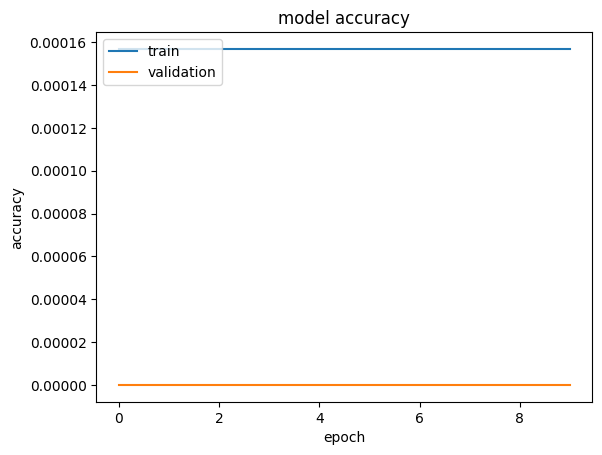

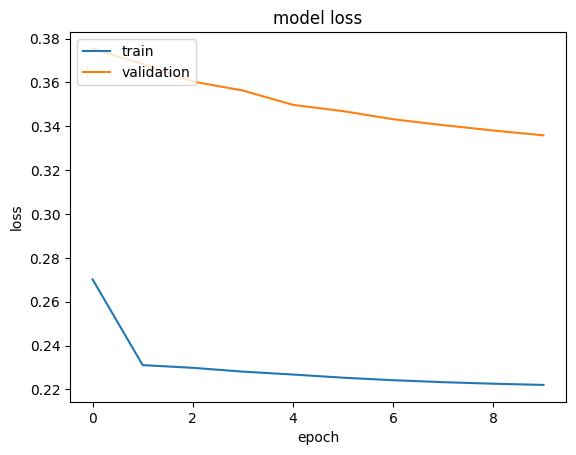

In [ ]:
# For LSTM
# _, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data(drop_features)

X_train, X_val, y_train, y_val, feature_names, feature_count = preprocess_data(
    drop_features, window_size, forecast_horizon
)


# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(window_size, feature_count)))
lstm_model.add(Dense(forecast_horizon, activation="sigmoid"))

# Compile the model
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Define early stopping with higher patience and monitoring validation accuracy
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# Define learning rate reduction
lr_reduction = ReduceLROnPlateau(
    monitor="val_loss", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)

# Fit the model
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping, lr_reduction],
)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_val) > 0.5).astype("int32")


# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

**LSTM Model** 🛰️

In [ ]:
# For LSTM
_, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data(drop_features)


# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile the model
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_test_lstm, y_test),
    verbose=1,
    shuffle=False,
)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

Epoch 1/10
90/90 [==============================] - 1s 5ms/step - loss: 0.6896 - accuracy: 0.5447 - val_loss: 0.6867 - val_accuracy: 0.5711
Epoch 2/10
90/90 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5940 - val_loss: 0.7048 - val_accuracy: 0.4807
Epoch 3/10
90/90 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.6950 - val_loss: 0.7512 - val_accuracy: 0.5131
Epoch 4/10
90/90 [==============================] - 0s 2ms/step - loss: 0.5190 - accuracy: 0.8379 - val_loss: 0.7750 - val_accuracy: 0.5698
Epoch 5/10
90/90 [==============================] - 0s 2ms/step - loss: 0.3822 - accuracy: 0.9175 - val_loss: 0.6786 - val_accuracy: 0.6515
Epoch 6/10
90/90 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.9612 - val_loss: 0.5349 - val_accuracy: 0.7313
Epoch 7/10
90/90 [==============================] - 0s 2ms/step - loss: 0.1774 - accuracy: 0.9819 - val_loss: 0.3513 - val_accuracy: 0.8410
Epoch 8/10
90/90 [==

**Feature Ablation +** ♟️

In [ ]:
results = {}

for feature in drop_features:
    # Exclude the current feature
    features = [f for f in drop_features if f != feature]

    # Preprocess the data using your function
    (
        X_train,
        X_test,
        X_train_lstm,
        X_test_lstm,
        y_train,
        y_test,
        feature_names,
    ) = preprocess_data(features)

    # Create the LSTM model
    model = KerasClassifier(
        build_fn=create_model,
        input_dim=X_train_lstm.shape[2],
        epochs=10,
        batch_size=72,
        verbose=0,
    )

    # Fit the model
    model.fit(X_train_lstm, y_train)

    # Predict the test set results
    y_pred = model.predict(X_test_lstm)

    # Calculate the accuracy
    acc = accuracy_score(y_test, y_pred)

    # Store the result
    results[feature] = acc

# Sort the results by accuracy
sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1])}

# Print the sorted results
for feature, acc in sorted_results.items():
    print(f"Accuracy without '{feature}': {acc}")

**Feature Ablation -** ⌚

In [ ]:
# Initialize a list to hold AUC-ROC scores for each iteration
auc_roc_lstm_history = []

for feature in feature_names:
    # Call your function to preprocess the data
    _, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data([feature])

    # Initialize the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1, activation="sigmoid"))

    # Compile the LSTM model
    lstm_model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    # Fit the LSTM model
    history = lstm_model.fit(
        X_train_lstm,
        y_train,
        epochs=10,
        batch_size=72,
        validation_data=(X_test_lstm, y_test),
        verbose=1,
        shuffle=False,
    )

    # Predict class labels for the test set
    y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

    # Compute AUC-ROC for the LSTM model
    auc_roc_lstm = roc_auc_score(y_test, y_pred_lstm)

    # Add the AUC-ROC score to the list
    auc_roc_lstm_history.append(auc_roc_lstm)

# Create a dictionary of features and their corresponding AUC-ROC scores
features_auc_roc_lstm_dict = dict(zip(feature_names, auc_roc_lstm_history))

# Create a sorted list of tuples from the dictionary
sorted_features_auc_roc_lstm = sorted(
    features_auc_roc_lstm_dict.items(), key=lambda item: item[1], reverse=True
)

# Print the sorted list
for feature, auc_roc in sorted_features_auc_roc_lstm:
    print(f"Feature: {feature}, AUC-ROC score: {auc_roc:.4f}")